# Modeling LC-SFC/MS data to augment separation scientists

The goal of this notebook is to give an overview of modeling ideas and approaches to model LC-SFC/MS data 

In [2]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline
import pandas as pd 
import rdkit
import h5py
import sys
import time
import numpy as np
import sklearn
import py3Dmol
import ipywidgets
import seaborn as sn
import matplotlib.pyplot as plt
import joblib



from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MACCSkeys
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score



from sklearn.feature_selection import VarianceThreshold
from pprint import pprint
from collections import defaultdict


from ipywidgets import interact,fixed,IntSlider



## Notebook Parameters
For traceability purposes, all parameters that are used when transforming data or make analysis is put in the below cell. These should preferably also be stored in the notebook output file. 

In [5]:
# set notebook parameters
datafile = 'Data/METLIN/dataset_withKallisto.csv'

## Now lets look at the pre-analysis data for retention time estimation
So now lets see if we can predict retention times based on the input molecule

In [6]:
rawData = pd.read_csv(datafile)
rawData = rawData.drop("Unnamed: 0", axis = 1);
print('The raw data shape is:',rawData.shape)

rawData.rename(columns={'rt': 'RetentionTime'}, inplace=True)

rawData.dropna(subset=['SMILES', 'RetentionTime', 'MolPol', 'IES'], inplace=True);
print('After removing rows without SMILES and retention time, the raw data shape is now:',rawData.shape)

rawData.head(3)

The raw data shape is: (79957, 6)
After removing rows without SMILES and retention time, the raw data shape is now: (79679, 6)


,pubchem,RetentionTime,inchi,SMILES,MolPol,IES
0,5139,93.5,"InChI=1S/C3H8N2S/c1-2-6-3(4)5/h2H2,1H3,(H3,4,5)",CCSC(=N)N,75.252525,-0.140576
1,3505,687.8,InChI=1S/C19H25Cl2N3O3/c1-27-19(26)23-8-9-24(1...,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...,272.214567,-0.300445
2,2159,590.7,InChI=1S/C17H27N3O4S/c1-4-20-8-6-7-12(20)11-19...,CCN1CCC[C@@H]1CN=C(O)c1cc(S(=O)(=O)CC)c(N)cc1OC,256.288278,-0.392000


The input data shape was: (79679, 4)


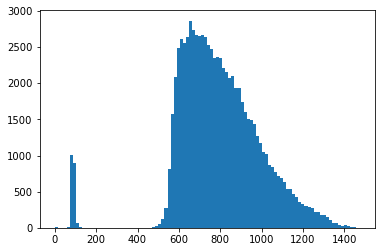

In [7]:
inputData = rawData[['RetentionTime', 'SMILES', 'MolPol', 'IES']]
retentionTime = rawData['RetentionTime']

print('The input data shape was:',inputData.shape)
plt.hist(inputData['RetentionTime'], bins=100);

The input data shape was: (79679, 4)


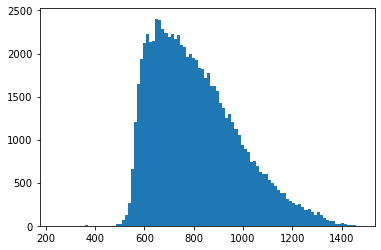

In [8]:
inputDataNew = inputData[inputData['RetentionTime']>200]
retentionTime = inputDataNew['RetentionTime']

print('The input data shape was:',inputData.shape)
plt.hist(inputDataNew['RetentionTime'], bins=100);

In [6]:
%%time
PandasTools.AddMoleculeColumnToFrame(inputDataNew,smilesCol='SMILES',includeFingerprints=True)


CPU times: user 1min 17s, sys: 1.17 s, total: 1min 18s
Wall time: 1min 20s


/home/kcrh009/anaconda3/envs/rdkitEnv/lib/python3.6/site-packages/rdkit/Chem/PandasTools.py:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(lambda smiles: _MolPlusFingerprint(


In [9]:
def getDescriptorsECFP4(dataframe): #change to 4!
    morganFingerprintRingSize = 2
    info={}
    ECFP6_hashed = [Chem.GetMorganFingerprintAsBitVect(x,morganFingerprintRingSize, nBits=1024, bitInfo=info) for x in dataframe['ROMol']]

    ECFP6_hashed_lists = [list(l) for l in ECFP6_hashed]
    ECFP6_hashed_name = [f'FpBit_{i}' for i in range(1024)]

    ECFP6_hashed_df = pd.DataFrame(ECFP6_hashed_lists, index = dataframe.index, columns=ECFP6_hashed_name)

    inputDataWithDescriptorsFull = pd.concat([dataframe, ECFP6_hashed_df], axis = 1)
    # remove fingerprints with no data (doesn't remove anything with fingerprints radius of 3)                           
    inputDataWithDescriptorsFull = inputDataWithDescriptorsFull.loc[:,(inputDataWithDescriptorsFull != 0).any(axis=0)]

    print('input data now has shape:', inputDataWithDescriptorsFull.shape)
    return inputDataWithDescriptorsFull

In [15]:
%%time
inputDataWithDescriptors = getDescriptorsECFP4(inputDataNew)
inputDataWithDescriptors.to_csv('Data/inputDataWithDescriptorsECFP4.csv')

input data now has shape: (77650, 1029)


KeyboardInterrupt: 

In [8]:
# Load instead of making
inputDataWithDescriptors = pd.read_csv('Data/inputDataWithDescriptorsECFP4.csv')
inputDataWithDescriptors.drop("Unnamed: 0", axis = 1, inplace=True);

,RetentionTime,SMILES,MolPol,IES,ROMol,FpBit_0,FpBit_1,FpBit_2,FpBit_3,FpBit_4,...,FpBit_1014,FpBit_1015,FpBit_1016,FpBit_1017,FpBit_1018,FpBit_1019,FpBit_1020,FpBit_1021,FpBit_1022,FpBit_1023
0,687.8,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...,272.214567,-0.300445,,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,590.7,CCN1CCC[C@@H]1CN=C(O)c1cc(S(=O)(=O)CC)c(N)cc1OC,256.288278,-0.392000,,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,583.6,Oc1cccc2c(O)nccc12,112.988057,-0.141635,,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0

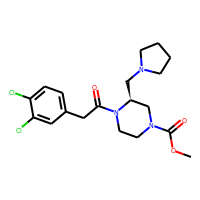
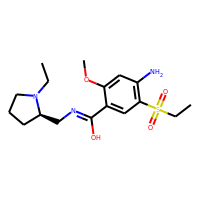
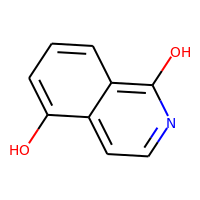

In [9]:
inputDataWithDescriptors.head(3)

In [10]:
#features_df = inputDataWithDescriptors.drop(['RetentionTime', 'SMILES', 'Ipc', 'ROMol', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge'], axis = 1)
features_df = inputDataWithDescriptors.drop(['RetentionTime', 'ROMol', 'SMILES'], axis = 1)
feature_list = list(features_df.columns)
features_full_df = features_df
features = np.array(features_df)

labels = np.array(inputDataWithDescriptors['RetentionTime'])


In [11]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

baseline = np.mean(train_labels)
baseline_error = test_labels-baseline


In [12]:
%%time
rf = joblib.load("Model/rfModelMetlin.joblib")
#rf = RandomForestRegressor(n_estimators = 150, random_state = 42)
#rf.fit(train_features, train_labels);
#joblib.dump(rf, "rfModel.joblib")

CPU times: user 370 ms, sys: 450 ms, total: 820 ms
Wall time: 954 ms


In [13]:
predictions = rf.predict(test_features)
rf_error = predictions - test_labels

Mean RF Error: 39.14 seconds.
Median RF Error: 23.21 seconds.
Mean Baseline Error: 141.7 seconds.


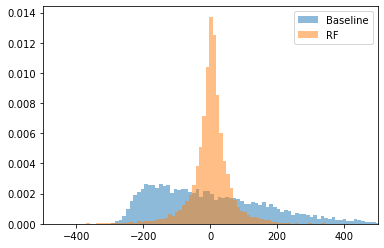

In [14]:
print('Mean RF Error:', round(np.mean(abs(np.array(rf_error))), 2), 'seconds.')
print('Median RF Error:', round(np.median(abs(np.array(rf_error))), 2), 'seconds.')

print('Mean Baseline Error:', round(np.mean(abs(np.array(baseline_error))),2), 'seconds.')

plt.hist(baseline_error, 100, alpha=0.5, label='Baseline', density=True);
plt.hist(rf_error, 100, alpha=0.5, label='RF', density=True)
plt.legend(loc='upper right')
plt.xlim(-500, 500)
plt.show()

In [15]:
inputNonKallisto = inputDataWithDescriptors.copy()
inputNonKallisto = inputNonKallisto.drop(["IES", "MolPol"], axis=1)
#inputNonKallisto = inputDataWithDescriptorsOld.drop(indexFailedKallisto)
print(inputNonKallisto.shape)

inputNonKallisto.dropna(inplace=True)

print(inputNonKallisto.shape)

(39886, 1027)
(39886, 1027)


In [16]:
inputNonKallisto.to_csv('Data/inputDataWithDescriptorsNonKallistoECFP.csv')

In [17]:
features_df_nonKallisto = inputNonKallisto.drop(['RetentionTime', 'SMILES', 'ROMol'], axis = 1)
feature_list_nonKallisto = list(features_df_nonKallisto.columns)
features_nonKallisto = np.array(features_df_nonKallisto)

labels_nonKallisto = np.array(inputDataWithDescriptors['RetentionTime'])

In [18]:
train_features_nonKallisto, test_features_nonKallisto, train_labels_nonKallisto, test_labels_nonKallisto = train_test_split(features_nonKallisto, labels_nonKallisto, test_size = 0.25, random_state = 42)

baseline_nonKallisto = np.mean(train_labels_nonKallisto)
baseline_error_nonKallisto = test_labels_nonKallisto-baseline_nonKallisto



In [19]:
%%time
rf_nonKallisto = joblib.load("Model/rfModel_nonKallistoMetlin.joblib")
#rf_nonKallisto = RandomForestRegressor(n_estimators = 150, random_state = 42)
#rf_nonKallisto.fit(train_features_nonKallisto, train_labels_nonKallisto);
#joblib.dump(rf_nonKallisto, "rfModel_nonKallisto.joblib")

CPU times: user 406 ms, sys: 325 ms, total: 731 ms
Wall time: 830 ms


In [20]:
%%time
predictions_nonKallisto = rf_nonKallisto.predict(test_features_nonKallisto)
rf_error_nonKallisto = predictions_nonKallisto - test_labels_nonKallisto

CPU times: user 970 ms, sys: 13 ms, total: 983 ms
Wall time: 1.01 s


Mean RF Error: 41.67 seconds.
Median RF Error: 24.99 seconds.
Mean Baseline Error: 141.7 seconds.


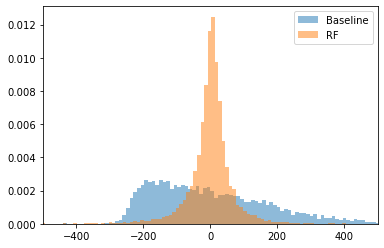

In [21]:
print('Mean RF Error:', round(np.mean(abs(np.array(rf_error_nonKallisto))), 2), 'seconds.')
print('Median RF Error:', round(np.median(abs(np.array(rf_error_nonKallisto))), 2), 'seconds.')

print('Mean Baseline Error:', round(np.mean(abs(np.array(baseline_error_nonKallisto))),2), 'seconds.')

plt.hist(baseline_error_nonKallisto, 100, alpha=0.5, label='Baseline', density=True);
plt.hist(rf_error_nonKallisto, 100, alpha=0.5, label='RF', density=True)
plt.legend(loc='upper right')
plt.xlim(-500, 500)
plt.show()

In [22]:
kallistoMean = round(np.mean(abs(np.array(rf_error))))
nonkallistoMean = round(np.mean(abs(np.array(rf_error_nonKallisto))))
                        
kallistoRmse = round(np.sqrt(np.mean(np.array(rf_error)**2)))
nonKallistoRmse = round(np.sqrt(np.mean(np.array(rf_error_nonKallisto)**2)))       
                     
print('Mean RF Error Validation on METLIN:', kallistoMean, 'seconds.')
print('Mean RF Error nonKallisto Validation on METLIN:', nonkallistoMean, 'seconds.')

print('RMSE for method Validation on METLIN:', kallistoRmse, 'seconds.')
print('RMSE for nonKallisto method Validation on METLIN:', nonKallistoRmse, 'seconds.')

print('Improvement in Validation MSE is', np.round((nonkallistoMean - kallistoMean)/nonkallistoMean*100,2))
print('Improvement in Validation RMSE is', np.round((nonKallistoRmse - kallistoRmse)/nonKallistoRmse*100,2))



Mean RF Error Validation on METLIN: 39 seconds.
Mean RF Error nonKallisto Validation on METLIN: 42 seconds.
RMSE for method Validation on METLIN: 62 seconds.
RMSE for nonKallisto method Validation on METLIN: 66 seconds.
Improvement in Validation MSE is 7.14
Improvement in Validation RMSE is 6.06


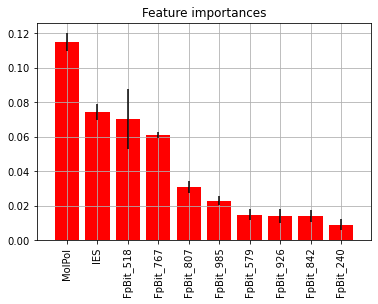

In [28]:
rfkallisto = rf
importances_full = rfkallisto.feature_importances_
std_full = np.std([tree.feature_importances_ for tree in rfkallisto.estimators_], axis=0)
indices_full = np.argsort(importances_full)[::-1]

k = 10
plt.figure()
plt.title("Feature importances")
plt.bar(range(k), importances_full[indices_full[0:k]],
        color="r", yerr=std_full[indices_full[0:k]], align="center")
plt.xticks(range(k), features_df.columns[indices_full[0:k]], rotation='vertical')
plt.xlim([-1, k])
plt.grid(True)

plt.savefig('Output/fullImportancesMETLIN.pdf')

plt.show()

## Feature reduction


In [21]:
def feature_reduction(features_df, low_var_thresh = 0.05, corr_thresh = 0.9):
    '''
    remove low variance and highly correlated features
    
    inputDf: the input dataframe
    
    '''
    # Remove low variance features
    selector = VarianceThreshold(low_var_thresh)
    selector.fit(features_df)
    high_var_df = features_df[features_df.columns[selector.get_support(indices=True)]]
    
    #remove high correlated features
    ## Create correlation matrix
    corr_matrix = high_var_df.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > corr_thresh)]
    
    return high_var_df.drop(high_var_df[to_drop], axis=1)


In [22]:
print('feature shape was', features_df_nonKallisto.shape)
features_reduced_nonKallisto = feature_reduction(features_df_nonKallisto)
print('reduced features are now', features_reduced_nonKallisto.shape)

feature shape was (39886, 1024)
reduced features are now (39886, 206)


In [23]:
print('feature shape was', features_df.shape)
features_reduced = features_reduced_nonKallisto.copy()
features_reduced = features_reduced.iloc[: , :-2]
features_reduced['MolPol'] = features_df['MolPol']
features_reduced['IES'] = features_df['IES']

print('reduced features are now', features_reduced.shape)

feature shape was (39886, 1026)
reduced features are now (39886, 206)


In [24]:
feature_list = list(features_reduced.columns)
features = np.array(features_reduced)

labels = np.array(inputDataWithDescriptors['RetentionTime'])

In [25]:
feature_list_nonKallisto = list(features_reduced_nonKallisto.columns)
features_nonKallisto = np.array(features_reduced_nonKallisto)

labels_nonKallisto = np.array(inputNonKallisto['RetentionTime'])

In [26]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
train_features_nonKallisto, test_features_nonKallisto, train_labels_nonKallisto, test_labels_nonKallisto = train_test_split(features_nonKallisto, labels_nonKallisto, test_size = 0.25, random_state = 42)

In [27]:
%%time
baseline = np.mean(train_labels)
baseline_error = test_labels-baseline


CPU times: user 106 µs, sys: 4 µs, total: 110 µs
Wall time: 114 µs


In [35]:
%%time
#rf_reduced = joblib.load("Model/rfModel_reducedMetlin.joblib")
rf_reduced = RandomForestRegressor( max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=150, random_state = 42)
rf_reduced.fit(train_features, train_labels);

#joblib.dump(rf_reduced, "Model/rfModel_reducedMetlin.joblib")

CPU times: user 1min 29s, sys: 9.14 ms, total: 1min 29s
Wall time: 1min 32s


RandomForestRegressor(max_depth=50, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=150, random_state=42)

In [36]:
predictions_reduced = rf_reduced.predict(test_features)
# Calculate the absolute errors
errors_reduced = predictions_reduced - test_labels

In [37]:
%%time
baseline_nonKallisto = np.mean(train_labels_nonKallisto)
baseline_error_nonKallisto = test_labels_nonKallisto-baseline_nonKallisto




CPU times: user 193 µs, sys: 4 µs, total: 197 µs
Wall time: 202 µs


In [31]:
%%time
rf_nonKallisto_reduced = joblib.load("Model/rfModel_nonKallistor_reducedMetlin.joblib")

#rf_nonKallisto_reduced = RandomForestRegressor( max_depth=50, min_samples_leaf=2, min_samples_split=5, n_estimators=150, random_state = 42)
#rf_nonKallisto_reduced.fit(train_features_nonKallisto, train_labels_nonKallisto);

#joblib.dump(rf_nonKallisto_reduced, "Model/rfModel_nonKallistor_reducedMetlin.joblib")

CPU times: user 114 ms, sys: 18 ms, total: 132 ms
Wall time: 178 ms


In [38]:
predictions_nonKallisto_reduced = rf_nonKallisto_reduced.predict(test_features_nonKallisto)
# Calculate the absolute errors
errors_nonKallisto_reduced = predictions_nonKallisto_reduced - test_labels_nonKallisto

In [39]:
print('Mean RF Error:', round(np.mean(abs(np.array(errors_reduced))), 2), 'seconds.')
print('Mean RF Error Non Kallisto:', round(np.mean(abs(np.array(errors_nonKallisto_reduced))), 2), 'seconds.')


Mean RF Error: 71.58 seconds.
Mean RF Error Non Kallisto: 78.29 seconds.


In [34]:
kallistoMean = round(np.mean(abs(np.array(errors_reduced))), 3)
nonKallistoMean = round(np.mean(abs(np.array(errors_nonKallisto_reduced))), 3)

kallistoRmse = round(np.sqrt(np.mean(np.array(errors_reduced)**2)), 3)
nonKallistoRmse = round(np.sqrt(np.mean(np.array(errors_nonKallisto_reduced)**2)), 3)

print('Mean RF Error Validation:', kallistoMean, 'seconds.')
print('Mean RF Error nonKallisto Validation:', nonKallistoMean, 'seconds.')

print('RMSE for method Validation:', kallistoRmse, 'seconds.')
print('RMSE for nonKallisto method Validation:', nonKallistoRmse, 'seconds.')

print('Improvement in Validation RMSE is', np.round((nonKallistoRmse-kallistoRmse)/kallistoRmse*100,3))

Mean RF Error Validation: 71.363 seconds.
Mean RF Error nonKallisto Validation: 78.293 seconds.
RMSE for method Validation: 100.059 seconds.
RMSE for nonKallisto method Validation: 107.651 seconds.
Improvement in Validation RMSE is 7.588


In [38]:
importances = rf_reduced.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
features_reduced.columns[indices[0:50]]

Index(['MolPol', 'IES', 'FpBit_136', 'FpBit_767', 'FpBit_842', 'FpBit_518',
       'FpBit_675', 'FpBit_23', 'FpBit_807', 'FpBit_989', 'FpBit_145',
       'FpBit_985', 'FpBit_659', 'FpBit_935', 'FpBit_121', 'FpBit_926',
       'FpBit_80', 'FpBit_904', 'FpBit_960', 'FpBit_242', 'FpBit_579',
       'FpBit_378', 'FpBit_720', 'FpBit_350', 'FpBit_799', 'FpBit_140',
       'FpBit_552', 'FpBit_392', 'FpBit_77', 'FpBit_456', 'FpBit_695',
       'FpBit_314', 'FpBit_294', 'FpBit_875', 'FpBit_73', 'FpBit_831',
       'FpBit_504', 'FpBit_672', 'FpBit_698', 'FpBit_932', 'FpBit_114',
       'FpBit_881', 'FpBit_175', 'FpBit_128', 'FpBit_248', 'FpBit_527',
       'FpBit_407', 'FpBit_325', 'FpBit_650', 'FpBit_271'],
      dtype='object')

In [39]:
test_list = features_reduced.columns[indices]=='MolPol'
res = next((i for i, j in enumerate(test_list) if j), None)
print ("MolPol importance is : " + str(res))


test_list = features_reduced.columns[indices]=='IES'
res = next((i for i, j in enumerate(test_list) if j), None)
print ("IES importance is : " + str(res))

MolPol importance is : 0
IES importance is : 1


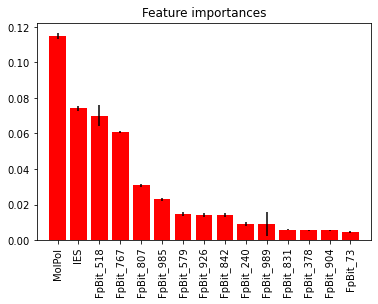

In [44]:
rfkallisto = rf
importances_full = rfkallisto.feature_importances_
std_full = np.std([tree.feature_importances_ for tree in rfkallisto.estimators_], axis=0)
indices_full = np.argsort(importances_full)[::-1]

k = 15
plt.figure()
plt.title("Feature importances")
plt.bar(range(k), importances_full[indices_full[0:k]],
        color="r", yerr=std_full[indices_full[0:k]], align="center")
plt.xticks(range(k), features_df.columns[indices_full[0:k]], rotation='vertical')
plt.xlim([-1, k])
plt.savefig('Output/fullImportances.pdf')

plt.show()

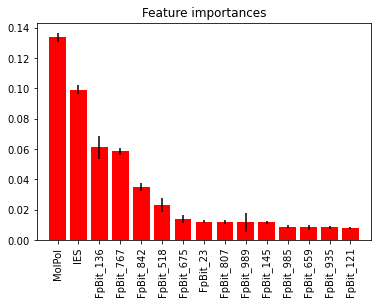

In [43]:
rf_reduced_kallisto = rf_reduced
importances_reduced = rf_reduced_kallisto.feature_importances_
std_reduced = np.std([tree.feature_importances_ for tree in rf_reduced_kallisto.estimators_], axis=0)
indices_reduced = np.argsort(importances_reduced)[::-1]

k = 15
plt.figure()
plt.title("Feature importances")
plt.bar(range(k), importances_reduced[indices_reduced[0:k]],
        color="r", yerr=std_reduced[indices_reduced[0:k]], align="center")
plt.xticks(range(k), features_reduced.columns[indices_reduced[0:k]], rotation='vertical')
plt.xlim([-1, k])
plt.savefig('Output/reducedImportances.pdf')

plt.show()

In [ ]:
rfkallisto = rf



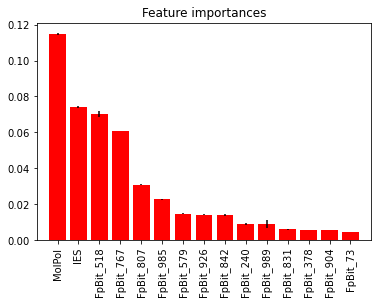

In [55]:
importances_full = rfkallisto.feature_importances_
std_full = np.std([tree.feature_importances_ for tree in rfkallisto.estimators_], axis=0)
indices_full = np.argsort(importances_full)[::-1]

k = 15
plt.figure()
plt.title("Feature importances")
plt.bar(range(k), importances_full[indices_full[0:k]],
        color="r", yerr=std_full[indices_full[0:k]]/10, align="center")
plt.xticks(range(k), features_df.columns[indices_full[0:k]], rotation='vertical')
plt.xlim([-1, k])
plt.savefig('Output/fullImportances.pdf')

plt.show()